In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds

In [2]:

etfs = [
    'SPY', 'VGK', 'IEF', 'LQD', 'USO', 'GLD', 'VNQ', 'RWO', 'IWM', 'HYG', 'DBC'
]

adj_close = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)

returns = adj_close.pct_change().dropna()

mean_returns = returns.mean() * 252  
cov_matrix = returns.cov() * 252  


In [3]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

In [4]:
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [5]:
def sharpe_ratio(weights, mean_returns, cov_matrix):
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    p_return = np.dot(weights, mean_returns)
    return -p_return / p_volatility  # Negative Sharpe ratio for minimization

In [6]:
# constraints: weights sum to 1, b/t 0 and 1 (no options or leveraging)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

In [7]:
# minimize the negative Sharpe ratio
optimal_sharpe = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights_sharpe = optimal_sharpe.x

opt_return, opt_volatility = portfolio_performance(optimal_weights_sharpe, mean_returns, cov_matrix)

print("Optimal Weights (Highest Sharpe Ratio):")
for i, weight in enumerate(optimal_weights_sharpe):
    print(f"{etfs[i]}: {weight:.4f}")
print(f"Return: {opt_return:.2f}, Risk: {opt_volatility:.2f}")

Optimal Weights (Highest Sharpe Ratio):
SPY: 0.3215
VGK: 0.0000
IEF: 0.6626
LQD: 0.0000
USO: 0.0000
GLD: 0.0159
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000
Return: 0.06, Risk: 0.06


In [8]:
def efficient_frontier(mean_returns, cov_matrix, num_points=500):
    results = np.zeros((3, num_points))
    weights = np.zeros((num_points, len(mean_returns)))
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_points)

    for i, target in enumerate(target_returns):
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target})
        bounds = tuple((0, 1) for asset in range(len(mean_returns)))
        initial_weights = np.ones(len(mean_returns)) / len(mean_returns)
        opt = minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        results[0, i] = opt.fun  # Portfolio standard deviation (volatility)
        results[1, i] = target   # Portfolio return
        results[2, i] = target / opt.fun  # Sharpe ratio
        weights[i, :] = opt.x

    return results, weights

In [9]:
results, weights = efficient_frontier(mean_returns, cov_matrix)

min_volatility_idx = np.argmin(results[0])
min_volatility = results[0, min_volatility_idx]
min_return = results[1, min_volatility_idx]


Portfolio 50 on Efficient Frontier
Return: -0.03, Volatility: 0.28
SPY: 0.0000
VGK: 0.0000
IEF: 0.2269
LQD: 0.0000
USO: 0.7731
GLD: 0.0000
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000


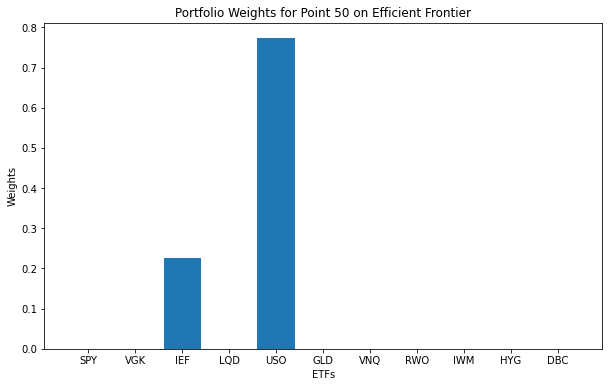


Portfolio 150 on Efficient Frontier
Return: 0.00, Volatility: 0.11
SPY: 0.0000
VGK: 0.0000
IEF: 0.6900
LQD: 0.0000
USO: 0.3100
GLD: 0.0000
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000


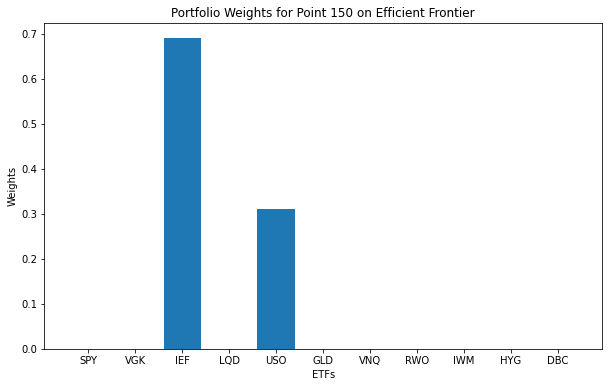


Portfolio 250 on Efficient Frontier
Return: 0.04, Volatility: 0.05
SPY: 0.0795
VGK: 0.0000
IEF: 0.6652
LQD: 0.0000
USO: 0.0000
GLD: 0.0000
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.2145
DBC: 0.0408


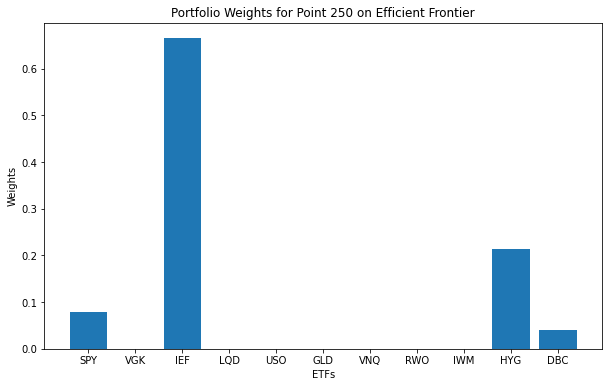


Portfolio 350 on Efficient Frontier
Return: 0.07, Volatility: 0.08
SPY: 0.4654
VGK: 0.0000
IEF: 0.5094
LQD: 0.0000
USO: 0.0000
GLD: 0.0252
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000


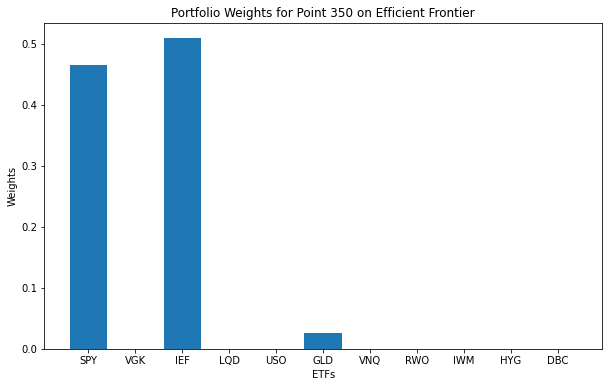


Portfolio 450 on Efficient Frontier
Return: 0.11, Volatility: 0.14
SPY: 0.8141
VGK: 0.0000
IEF: 0.1358
LQD: 0.0000
USO: 0.0000
GLD: 0.0501
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000


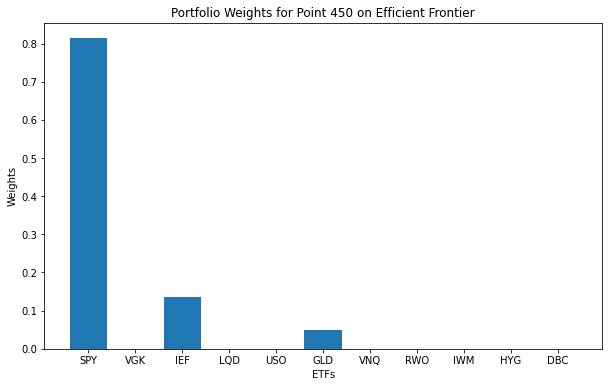


Portfolio 500 on Efficient Frontier
Return: 0.13, Volatility: 0.18
SPY: 1.0000
VGK: 0.0000
IEF: 0.0000
LQD: 0.0000
USO: 0.0000
GLD: 0.0000
VNQ: 0.0000
RWO: 0.0000
IWM: 0.0000
HYG: 0.0000
DBC: 0.0000


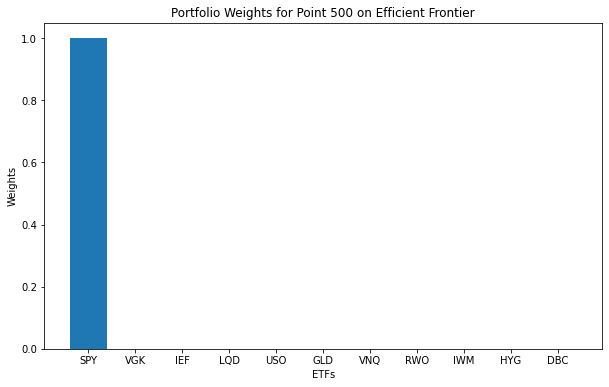

In [10]:
selected_points = [49, 149,249,349,449,499]

for i in selected_points:
    print(f"\nPortfolio {i+1} on Efficient Frontier")
    print(f"Return: {results[1, i]:.2f}, Volatility: {results[0, i]:.2f}")
    for j, weight in enumerate(weights[i, :]):
        print(f"{etfs[j]}: {weight:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(etfs, weights[i, :])
    plt.xlabel('ETFs')
    plt.ylabel('Weights')
    plt.title(f"Portfolio Weights for Point {i+1} on Efficient Frontier")
    plt.show()


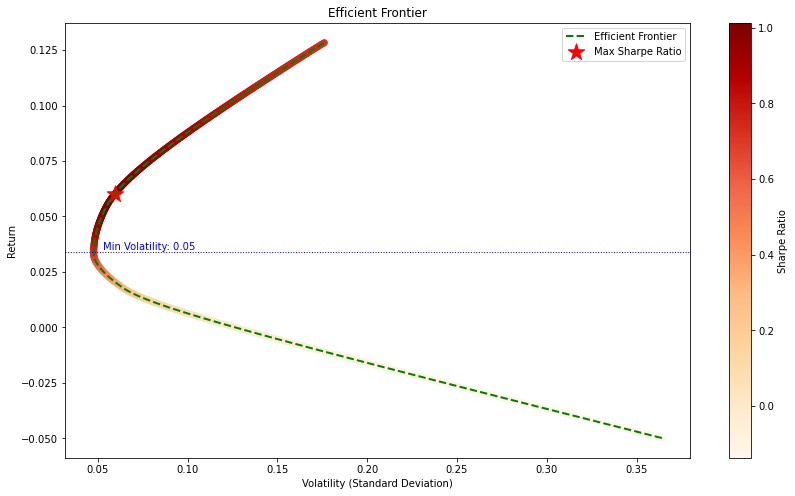

In [11]:
plt.figure(figsize=(14, 8), facecolor='white')
plt.plot(results[0,:], results[1,:], 'g--', linewidth=2, label='Efficient Frontier')
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='OrRd', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_volatility, opt_return, marker='*', color='r', s=300, label='Max Sharpe Ratio')

plt.axhline(y=min_return, color='blue', linestyle='dotted', linewidth=1)
plt.text(min_volatility + 0.005, min_return, f"Min Volatility: {min_volatility:.2f}", 
         verticalalignment='bottom', color='blue')

plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend(loc='best')
plt.show()

     Mean Return  Standard Deviation
SPY     0.128385            0.176113
VGK     0.067248            0.218388
IEF     0.027246            0.064409
LQD     0.038190            0.075998
USO    -0.049915            0.364107
GLD     0.045851            0.156849
VNQ     0.108857            0.210734
RWO     0.074067            0.189860
IWM     0.116672            0.225414
HYG     0.046898            0.087867
DBC     0.016340            0.175570


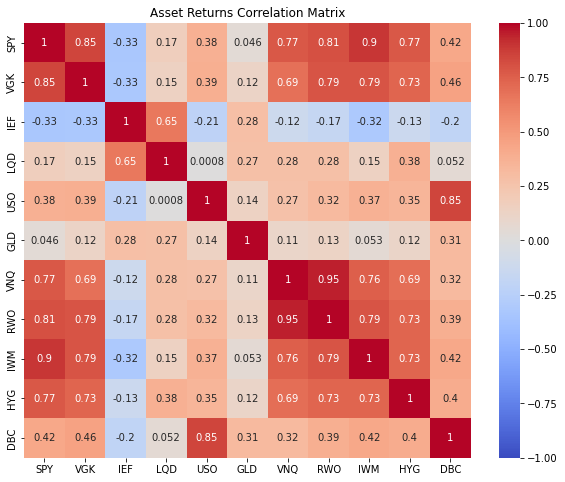

In [12]:
import seaborn as sns

mean_returns = returns.mean() * 252
std_devs = returns.std() * np.sqrt(252)
corr_matrix = returns.corr()

asset_stats = pd.DataFrame({
    'Mean Return': mean_returns,
    'Standard Deviation': std_devs
})

print(asset_stats)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Returns Correlation Matrix')
plt.show()